# Assignemnent for Udacity Data Scientist Nanodegree: Chocolate Bar Ratings

We will first import all packages and read the file we are going to work with. For this assignment, I've selected Chocolate Bar Ratings dataset from kaggle.  

In [1]:
import pandas as pd
import numpy as np
import country_converter as coco

df = pd.read_csv("flavors_of_cacao.csv")

## Data processing

We can have an initial look on the dataset.  

In [2]:
print("The dataset has {} observations and {} variables.".format(df.shape[0],df.shape[1]))
df.head()

The dataset has 1795 observations and 9 variables.


,Company (Maker-if known),Specific Bean Origin or Bar Name,REF,Review Date,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,A. Morin,Agua Grande,1876,2016,63%,France,3.75,,Sao Tome
1,A. Morin,Kpime,1676,2015,70%,France,2.75,,Togo
2,A. Morin,Atsane,1676,2015,70%,France,3.00,,Togo
3,A. Morin,Akata,1680,2015,70%,France,3.50,,Togo
4,A. Morin,Quilla,1704,2015,70%,France,3.50,,Peru


We will first preprocess column names because they have additional lines, which can be confusing when we will be calling the  column names later on. We will process them to a single line and remove all white spaces.

In [3]:
#Remove all spaces and lines from the column names. 

tmp_cols = [i.replace('\n',' ') for i in df.columns] 
tmp_cols[0] = tmp_cols[0].replace(u'\xa0', u' ')
tmp_cols = [i.replace(' ','') for i in tmp_cols] 
df.columns = tmp_cols

Some of the countries names are misplelled or don't have uniform name in columns CompanyLocation and 
BroadBeanOrigin. We will try to clean this at least a bit using country_converter package.  

In [4]:
#Manually correct all obvious mistakes in country spelling. 

df = df.replace("Domincan Republic","Dominican Republic")
df = df.replace("Hawaii","United States")
df = df.replace("Cost Rica, Ven","Costa Rica, Venezuela")
df = df.replace("Niacragua","Nicaragua")
df = df.replace("Eucador","Ecuador")
df = df.replace("Mad., Java, PNG","Madagascar, Java, Papua New Guinea")
df = df.replace(r'^Ven\,',"Venezuela", regex=True)
df = df.replace("Amsterdam","Netherlands")
df = df.replace("Scotland","United Kingdom")
df = df.replace("Wales","United Kingdom")

#Apply country_convert to convert all "non-standardized" country names if possible.

cleaned_country_names = coco.convert(names = list(df["BroadBeanOrigin"]), to = 'name_short')
df["BroadBeanOrigin"] = cleaned_country_names

cleaned_country_names = coco.convert(names = list(df["CompanyLocation"]), to = 'name_short')
df["CompanyLocation"] = cleaned_country_names

We can also generate information about continents for the dataset. This could be handy later on.

In [5]:
#Generate continents for the given country name.
continent = coco.convert(names = list(df["BroadBeanOrigin"]), to = 'continent')

#For the sake of bravity, when there is multiple continents per entry, keep only the first one. 
#This is not the best practice, but there are only few entries with different continents, so this should not affect
#the result substantially

for i in range(len(continent)):
    if type(continent[i]) == list:
        continent[i] = list(set(continent[i]))[0]       

df["ContinentBeanOrigin"] = continent

Some of the processed names which have more than two entities are converted to lists by country converter. We will take care by converting them to string and using regular expression to remove excessive characters. 

In [7]:
df["BroadBeanOrigin"] = df.BroadBeanOrigin.astype(str).str.replace('\[|\]|\'', '')

Furthermore, we can see that there are some blank cells (e.g in BeanType) or cells "not found" (e.g in BroadBeanOrigin). We will replace them with NaNs.  

In [8]:
df = df.replace(r'^\s*$', np.nan, regex = True)

df = df.replace(r'^not found$', np.nan, regex = True)


Columns BeanType, BroadBeanOrigin, and ContinentBeanOrigin have missing values. We can check percentage of NaNs in each column: 

In [10]:
df.isna().mean(axis = 0)

Company(Maker-ifknown)         0.000000
SpecificBeanOriginorBarName    0.000000
REF                            0.000000
ReviewDate                     0.000000
CocoaPercent                   0.000000
CompanyLocation                0.000000
Rating                         0.000000
BeanType                       0.494708
BroadBeanOrigin                0.054596
ContinentBeanOrigin            0.054596
dtype: float64

We also notice that CocoaPercent is storing strings. It is more convenient to convert them to floats. 

In [12]:
df.dtypes

df["CocoaPercent"] = df["CocoaPercent"].str.strip("%").astype('float') / 100

Company(Maker-ifknown)          object
SpecificBeanOriginorBarName     object
REF                              int64
ReviewDate                       int64
CocoaPercent                   float64
CompanyLocation                 object
Rating                         float64
BeanType                        object
BroadBeanOrigin                 object
ContinentBeanOrigin             object
dtype: object

Now when we finally prepared the dataset, we can focus on specific questions related to the dataset. 

## Question 1: Which chocolates have the highest rating?

First, we are interested in chocolates with highest rating - we can see that two chocolates from the Italian company Amedei have the perfect 5.0 rating. 

In [13]:
df.sort_values("Rating",ascending = False).head()

,Company(Maker-ifknown),SpecificBeanOriginorBarName,REF,ReviewDate,CocoaPercent,CompanyLocation,Rating,BeanType,BroadBeanOrigin,ContinentBeanOrigin
78,Amedei,Chuao,111,2007,0.70,Italy,5.0,Trinitario,Venezuela,America
86,Amedei,Toscano Black,40,2006,0.70,Italy,5.0,Blend,NaN,NaN
222,Bonnat,Kaori,1339,2014,0.75,France,4.0,NaN,Brazil,America
76,Amedei,Porcelana,111,2007,0.70,Italy,4.0,Criollo (Porcelana),Venezuela,America
1663,Tobago Estate (Pralus),"Roxborough, Tobago",895,2012,0.70,France,4.0,Trinitario,Trinidad and Tobago,America


We see that the among the five highest rated chocolates, company location is either Italy or France. How does the prevalence of countries look for the best rated chocolates?

## Question 2: Which countries produce the best chocolate?

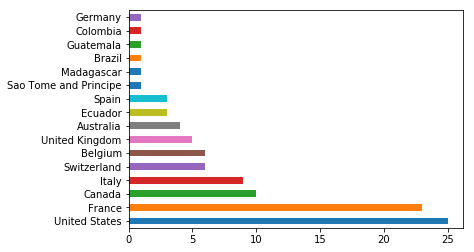

In [15]:
df[df["Rating"] >= 4.0].CompanyLocation.value_counts().plot.barh()

I never thought of USA as the land of the best chocolate. What if normalize the counts to the overall number of tested chocolates from the specific country?

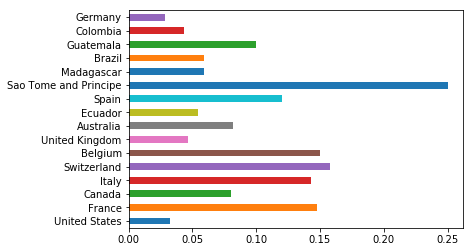

In [16]:
best_counts = df[df["Rating"] >= 4.0].CompanyLocation.value_counts()

overall_counts = df.CompanyLocation.value_counts()[best_counts.keys()]

(best_counts / overall_counts).plot.barh()

## Question 3: Where does the cocoa bean from best chocolates come from?

Similarly, I am intersted if the origin of cocoa bean has something to do with the taste of chocolate? We will look at the barplot. 

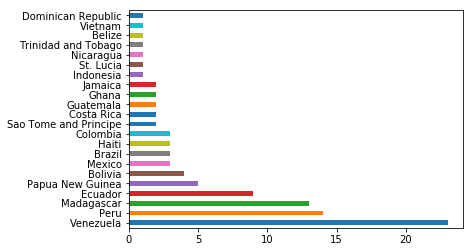

In [17]:
best_counts = df[df["Rating"] >= 4.0].BroadBeanOrigin.str.split(", ").apply(pd.Series,1).stack()

best_counts.value_counts().plot.barh()

This plot indicates that Venezuela has the best chocolate beans. However, Venezuela also has the highest number of chocolate beans production overall, so I am not sure if we can say that Venezuela has the best chocolate beans. 

We can now look the same thing across the continents.


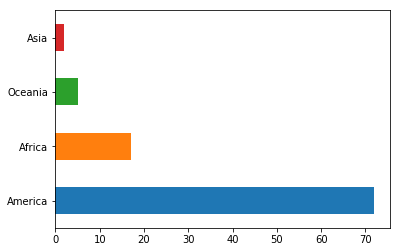

In [18]:
best_counts = df[df["Rating"] >= 4.0].ContinentBeanOrigin.str.split(", ").apply(pd.Series,1).stack()

best_counts.value_counts().plot.barh()

## Question 4: Do beans grown on different continents yield different amount of chocolate?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000221C932D828>,
      dtype=object)

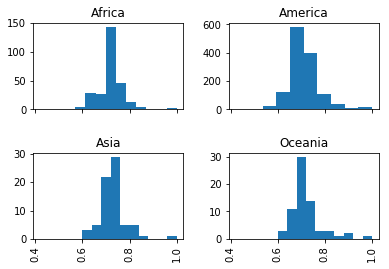

In [19]:
df.CocoaPercent.hist(by =df["ContinentBeanOrigin"],sharex = True)

## Question 5: Does the Cocoa Percent influence the rating?

Finally, we can make simple plots to explore if Cocoa percent influences the Chocolate Rating. It would be really easy for chocolate producers if there is a clear relationship.

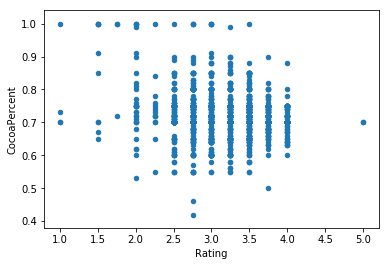

In [20]:
df[["Rating","CocoaPercent"]].plot.scatter("Rating","CocoaPercent")

## Bonus question: Can we predict the chocolate rating using other variables in the dataset?

Unforunatelly, there does not seem to be enough information to develop predictive models to predict rating of chocolate using other variables. However, we learnt something new today using simple descriptive analysis :-)